## Problem 3 - Asset Pricing - Group Assignment

In [53]:
# Libraries we will need
# (same as the ones we use in Problem 1)

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib as plt
import openpyxl as opl
import statistics as st
import scipy as sp

# Read data
portfolio = pd.read_csv('../Problem1/data/25_Portfolios_5x5.csv', parse_dates= True, index_col='DATE', infer_datetime_format=True)
portfolio.index = pd.to_datetime(portfolio.index, format="%Y%m")

# Calculate average returns

inv_df = pd.read_csv('Portfolios_Formed_on_INV.csv',  index_col = "DATE")
inv_df.index = pd.to_datetime(inv_df.index, format="%Y%m")

inv_df['RM'] = np.round((inv_df['Lo 30'] + inv_df['Med 40'] + inv_df['Hi 30'])/3,4)

risk_free = pd.read_csv('../Problem1/data/RF_Data.csv', index_col = "DATE")
risk_free.index = pd.to_datetime(risk_free.index, format = "%Y%m")


# Merge together
df = pd.merge(left = inv_df, right = risk_free, how = "inner", on = "DATE")

# Excess returns (rewrite old variables for simplicity)
df["Lo 10"] = df["Lo 10"] - df["RF"]
df["2-Dec"] = df["2-Dec"] - df["RF"]
df["3-Dec"] = df["3-Dec"] - df["RF"]
df["4-Dec"] = df["4-Dec"] - df["RF"]
df["5-Dec"] = df["5-Dec"] - df["RF"]
df["6-Dec"] = df["6-Dec"] - df["RF"]
df["7-Dec"] = df["7-Dec"] - df["RF"]
df["8-Dec"] = df["8-Dec"] - df["RF"]
df["9-Dec"] = df["9-Dec"] - df["RF"]
df["Hi 10"] = df["Hi 10"] - df["RF"]
df["RM"] = df["RM"] - df["RF"]


In [54]:
# Regression dataset

reg_df = df[["RM","Lo 10", "2-Dec", "3-Dec", "4-Dec", "5-Dec", "6-Dec", "7-Dec", "8-Dec", "9-Dec", "Hi 10"]]


# Estimate CAPM regression for each investment decile
import statsmodels.api as sm

output_df = pd.DataFrame(columns = ["var","alpha", "beta"])

for i in reg_df.columns:
    if(i != 'RM'):
        factors = sm.add_constant(reg_df['RM'])
        mod = sm.OLS(reg_df[i], factors)
        res = mod.fit(cov_type="HC0") # Heteroskedasticity-robust errors
        aux_df = {"var": [i], "alpha": [res.params['const']], "beta": [res.params['RM']]}
        aux_df = pd.DataFrame(aux_df)
        output_df = output_df.append(aux_df)


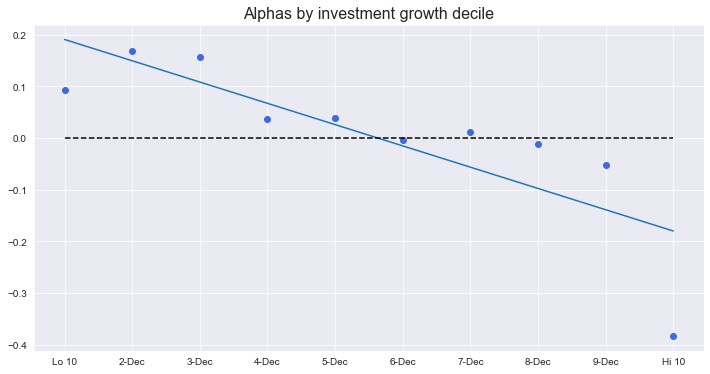

In [55]:
# Plot results
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

fig = plt.figure(figsize=(12, 6))
fig = plt.plot(output_df['var'], output_df['alpha'], 'o',color = "royalblue")
output_df['seq'] = np.array([1,2,3,4,5,6,7,8,9,10])
m, b = np.polyfit(np.array(output_df['seq']), np.array(output_df['alpha']), 1) # Linear regression
output_df['line'] = m*output_df['seq'] + b
fig = plt.plot(output_df['var'], output_df['line'])
fig = plt.plot(np.repeat(0,10), linestyle = 'dashed', color = 'black')
fig = plt.title("Alphas by investment growth decile", size = 16)
fig = plt.savefig("alphas_by_investment_decile.jpg")
fig = plt.show()

In [56]:
# Define investment growth factor (IGF)

df['inv_factor'] = df['Lo 30'] - df['Hi 30']

# Calculate average market return

#portfolio['RM'] = portfolio.apply(np.mean, axis = 0) # Not necessary. Already in Fama-Frech data

factor_df = pd.read_csv("F-F_Research_Data_Factors.csv", index_col = "DATE")
factor_df.index = pd.to_datetime(factor_df.index, format= "%Y%m")

# Subtract RF on all columns so that we have excess returns.
# Importantly, note that this is the original, unaltered dataset,
# not the one in which we had already substracted the risk-free rate.

factor_df_adj = pd.merge(left = portfolio, right = factor_df['RF'], on = 'DATE', how = 'inner')

for i in factor_df_adj:
    if(i != 'RF'):
        factor_df_adj[i] = factor_df_adj[i] - factor_df_adj['RF']


# Run 2 regressions for every portfolio.
# One with the investment factor, one without

factor_df_adj = pd.merge(left = factor_df_adj, right = factor_df[["RM", "SMB", "HML"]], on = 'DATE', how = 'inner')
factor_df_adj = pd.merge(left = factor_df_adj, right = df['inv_factor'], on = "DATE", how = "inner")

# Note that RM = Mkt-RF already
factors_ni = sm.add_constant(factor_df_adj[["RM","SMB","HML"]])
factors_i = sm.add_constant(factor_df_adj[["RM","SMB","HML","inv_factor"]])

# Auxilliary DataFrame where we will paste all of our regression outputs
df_outputs = pd.DataFrame(columns = ['portfolio','alpha_ni', 'rsq_ni','tstat_ni','rss_ni',
                                     'alpha_i', 'beta_i', 'rsq_i','tstat_i','rss_i'])

df_aux_reg = factor_df_adj.drop(['RF','SMB','HML','inv_factor','RM'], axis = 1)

# Residuals matrices
# For all the following variables:
# ni : No investment growth factor
# i : Using the investment growth factor

resid_ni = pd.DataFrame()
resid_i = pd.DataFrame()

for i in df_aux_reg.columns:
    mod_ni = sm.OLS(factor_df_adj[i], factors_ni)
    res_ni = mod_ni.fit(cov_type="HC0")
    mod_i = sm.OLS(factor_df_adj[i], factors_i)
    res_i = mod_i.fit(cov_type="HC0")
    beta_i = res_i.params.loc['inv_factor'].astype('float')
    resid_i[f'res {i}'] = res_i.resid
    resid_ni[f'res {i}'] = res_ni.resid
    aux_df = {'portfolio': [i],
                'alpha_ni' : np.round([res_ni.params.loc['const']],2),
                'rsq_ni' : np.round([res_ni.rsquared_adj],4), # Less rounding because we will compare it
                'tstat_ni' : np.round([res_ni.tvalues[0]],2),
                'rss_ni' : np.round([res_ni.ssr],2),
                'alpha_i' : np.round([res_i.params.loc['const']],2),
                'beta_i': np.round(beta_i,2),
                'rsq_i' : np.round([res_i.rsquared_adj],4), # Less rounding because we will compare it
                'tstat_i' : np.round([res_i.tvalues[0]],2),
                'rss_i' : np.round([res_i.ssr],2)}
    aux_df = pd.DataFrame(aux_df)
    df_outputs = df_outputs.append(aux_df)

# compare 
df_outputs['rsq_diff'] = df_outputs['rsq_i'] - df_outputs['rsq_ni']

print(df_outputs)


    portfolio  alpha_ni  rsq_ni  tstat_ni   rss_ni  alpha_i  beta_i   rsq_i  \
0  SMALL LoBM     -0.47  0.9099     -5.35  3968.57    -0.47   -0.06  0.9099   
0     ME1 BM2      0.02  0.9267      0.29  2472.52     0.02   -0.00  0.9266   
0     ME1 BM3     -0.03  0.9527     -0.69  1203.06    -0.03   -0.00  0.9526   
0     ME1 BM4      0.14  0.9501      2.83  1184.02     0.15   -0.03  0.9501   
0  SMALL HiBM      0.17  0.9075      2.59  2553.70     0.16    0.03  0.9074   
0     ME2 BM1     -0.18  0.9453     -2.79  1950.70    -0.19    0.03  0.9453   
0     ME2 BM2      0.02  0.9459      0.39  1371.80     0.01    0.10  0.9468   
0     ME2 BM3      0.05  0.9283      0.94  1518.81     0.04    0.07  0.9287   
0     ME2 BM4      0.05  0.9465      1.03  1065.23     0.04    0.06  0.9469   
0     ME2 BM5      0.01  0.9518      0.17  1293.34     0.01   -0.01  0.9518   
0     ME3 BM1     -0.10  0.9459     -1.68  1622.44    -0.09   -0.10  0.9466   
0     ME3 BM2      0.07  0.9211      1.21  1669.57  

In [59]:

# Sharpe ratio for GSR test
# This code it taken from the GRS test we perform in Question 2

# Mean of all the factors used
mean_SMB = factor_df_adj['SMB'] - factor_df_adj['SMB'].mean(axis = 0)
mean_HML = factor_df_adj['HML'] - factor_df_adj['HML'].mean(axis = 0)
mean_I = factor_df_adj['inv_factor'] - factor_df_adj['inv_factor'].mean(axis = 0)
mean_RM  = factor_df_adj['RM'] - factor_df_adj['RM'].mean(axis = 0)

matrix_ni = np.zeros((3,3))
matrix_i = np.zeros((4,4))

for i in range(len(factor_df_adj)):
    vector_ni = np.array( [mean_SMB[i], mean_HML[i], mean_RM[i]])
    matrix_ni = matrix_ni + np.outer(vector_ni, vector_ni)
    vector_i = np.array( [mean_SMB[i], mean_HML[i], mean_I[i], mean_RM[i]])
    matrix_i = matrix_i + np.outer(vector_i, vector_i)

# Invert the covariance matrices

omega_inv_ni = np.linalg.inv(matrix_ni/len(factor_df_adj))
omega_inv_i = np.linalg.inv(matrix_i/len(factor_df_adj))

factor_means_ni = np.array([factor_df_adj['SMB'].mean(axis = 0), factor_df_adj['HML'].mean(axis = 0),
                            factor_df_adj['RM'].mean(axis = 0)])
factor_means_i = np.array([factor_df_adj['SMB'].mean(axis = 0), factor_df_adj['HML'].mean(axis = 0),
                            factor_df_adj['inv_factor'].mean(axis = 0), factor_df_adj['RM'].mean(axis = 0)])
t = len(factor_df_adj)
n = 25 # number of assets (i.e. portfolios)
k_ni = 3 # number of factors
k_i = 4 # number of factors
alpha_ni = df_outputs["alpha_ni"]
alpha_i = df_outputs["alpha_i"]

covariance_resid_i = np.linalg.inv((resid_i.T @ resid_i)/t)
covariance_resid_ni = np.linalg.inv((resid_ni.T @ resid_ni)/t)

GRS_stat_i = ((t - n - k_i)/n)*(1/(1 + factor_means_i.T @ omega_inv_i @ factor_means_i))*(alpha_i.T @ covariance_resid_i @ alpha_i)
GRS_stat_ni = ((t - n - k_i)/n)*(1/(1 + factor_means_ni.T @ omega_inv_ni @ factor_means_ni))*(alpha_ni.T @ covariance_resid_ni @ alpha_ni)
p_value_i = 1 - sp.stats.f.cdf(GRS_stat_i, n, t - n - k_i)
p_value_ni = 1 - sp.stats.f.cdf(GRS_stat_ni, n, t - n - k_ni)
print(f"GRS stat without investment growth factor: {np.round(GRS_stat_ni,2)} ; p-value: {np.round(p_value_ni,2)}")
print(f"GRS stat with investment growth factor: {np.round(GRS_stat_i,2)} ; p-value: {np.round(p_value_i,2)}")


GRS stat without investment growth factor: 3.52 ; p-value: 0.0
GRS stat with investment growth factor: 3.74 ; p-value: 0.0
